![windowitz](windowitz.png)

## EE378A Final Project, Spring 2016
### Leighton Barnes, Raghav Subramaniam, Sahaana Suri

In [1]:
import sys
import os

import numpy as np
from scipy import io

import matplotlib.pyplot as plt
%matplotlib notebook

import cvxpy

## Get Test Data

Note: `test.mat` should contain the test data (not supplied by us).

In [2]:
mat_dict = io.loadmat('test.mat')

test_cl = mat_dict['test_cl']
test_hi = mat_dict['test_hi']
test_lo = mat_dict['test_lo']
test_op = mat_dict['test_op']
test_vol = mat_dict['test_vol']
numDays, numStocks = test_cl.shape

all_stocks = []
for i in range(numStocks):
    all_stocks.append(np.array_str(mat_dict['test_stocks'][0][i])[3:-2])

## Get Train Data

Note: `portfolio.mat` contains the train data (supplied by us).

In [3]:
mat_dict = io.loadmat('portfolio.mat')

train_cl = mat_dict['train_cl']
train_hi = mat_dict['train_hi']
train_lo = mat_dict['train_lo']
train_op = mat_dict['train_op']
train_vol = mat_dict['train_vol']
numTrain, _ = train_cl.shape

# make data compatible with our algorithms
train_cl = train_cl.T
train_op = train_op.T

## Choose Stocks

In [4]:
fsdax = [455, 47, 322, 216, 190, 269, 106, 389]
fscsx = [304, 197, 456, 279, 338, 112, 7, 227]
fbsox = [456, 279, 118, 6, 227, 179, 178]
fbiox = [84, 60, 192]
the_sahaana_special = [467, 457, 469, 486, 283, 221, 256, 34, 227, 187]

fundStocks = np.unique(fsdax + fscsx + fbsox + fbiox + the_sahaana_special)
numFundStocks = len(fundStocks)

print fundStocks

[  6   7  34  47  60  84 106 112 118 178 179 187 190 192 197 216 221 227
 256 269 279 283 304 322 338 389 455 456 457 467 469 486]


## Windowitz Algorithm

In [5]:
# params
window_size = 375
update_interval = 110
eta = 0.03
mu = 10

# build initial p matrix
p_init = np.zeros([numFundStocks, numTrain])

for curr_t in range(1, numTrain):
        
    nan_locs = np.where(np.logical_or(np.isnan(train_cl[fundStocks, curr_t-1]),
               np.isnan(train_cl[fundStocks, curr_t])))[0]
    non_nan_locs = np.where(np.logical_and(np.isfinite(train_cl[fundStocks, curr_t-1]),
                   np.isfinite(train_cl[fundStocks, curr_t])))[0]
        
    p_init[nan_locs, curr_t] = 0
    p_init[non_nan_locs, curr_t] = (train_cl[fundStocks,:][non_nan_locs, curr_t]
        - train_cl[fundStocks,:][non_nan_locs, curr_t-1]) / train_cl[fundStocks,:][non_nan_locs, curr_t-1]
    
# matrices to cache test data
cls = np.zeros([numStocks, numDays])
ops = np.zeros([numStocks, numDays])

def windowitz(t, portfolio_t, hi, lo, cl, op, stocks, vol):
    
    # save data
    cls[:, t] = cl.T
    ops[:, t] = op.T
    
    if t % update_interval is 0:
    
        # build p matrix
        p = np.zeros([numFundStocks, t])
        
        for curr_t in range(1, t):
            nan_locs = np.where(np.logical_or(np.isnan(cls[fundStocks, curr_t-1]),
                       np.isnan(cls[fundStocks, curr_t])))[0]
            #print nan_locs
            non_nan_locs = np.where(np.logical_and(np.isfinite(cls[fundStocks, curr_t-1]),
                           np.isfinite(cls[fundStocks, curr_t])))[0]
        
            p[nan_locs, curr_t] = 0
            p[non_nan_locs, curr_t] = (cls[fundStocks,:][non_nan_locs, curr_t]
                - cls[fundStocks,:][non_nan_locs, curr_t-1]) / cls[fundStocks,:][non_nan_locs, curr_t-1]
        
        # compute statistics
        pbar = np.mean(np.hstack([p_init, p])[:, t+numTrain-window_size:t+numTrain-1], axis=1)
        sigma = np.cov(np.hstack([p_init, p])[:, t+numTrain-window_size:t+numTrain-1])
    
        # set up and solve markowitz problem
        b_opt = cvxpy.Variable(numFundStocks)
        objective = cvxpy.Minimize(-pbar*b_opt + mu*cvxpy.quad_form(b_opt, sigma)
                    + eta*cvxpy.pnorm(b_opt - portfolio_t[fundStocks], 2))
        constraints = [cvxpy.sum_entries(b_opt) >= 0.01, cvxpy.sum_entries(b_opt) <= 1.0]
        problem = cvxpy.Problem(objective, constraints)
        problem.solve(verbose=False, solver='ECOS')
                           
        b_opt = b_opt.value
        
        portfolio = np.zeros(numStocks)
        portfolio[fundStocks] = b_opt
        
        portfolio /= np.sum(portfolio)
    
        return portfolio, np.zeros(numStocks, dtype=bool)
    
    else:
        
        return portfolio_t, np.ones(numStocks, dtype=bool)

## Framework Code

In [6]:
def rebalance(value_vec, value_realizable, portfolio_dst, cost_rate):
    """ % This function simulates the process of rebalancing. The key difficulty 
    % here is to compute the transaction cost, i.e., to solve the equation
    %
    % sum( cost_rate * abs( portfolio_dst .* (value_realizable - C) -
    % value_vec) ) = C
    % 
    % where C is the total transcation cost. We use the Banach contraction 
    % theorem to solve this equation, with convergence rate cost_rate^t for 
    % t-th iteration. 

    % Input: 
    %%% value_vec: current values of each active stock
    %%% value_realizable: total cash realizable value
    %%% portfolio_dst: the desired portfolio after rebalancing
    %%% cost_rate: ratio of transactions cost (0.0005 in our case)

    % Output:
    %%% new_value_vec: the value vector after rebalancing
    %%% trans_cost: the total transaction cost"""
    
    if len(portfolio_dst)==0:
        new_value_vec = value_vec
        trans_cost = 0
    else:
        len_noHold = value_vec.size
        C_candidate = np.append([0], value_realizable - value_vec / portfolio_dst)
        x = np.sort(C_candidate)
        x[np.logical_or(np.isinf(x),np.isnan(x))] = 1e15
        x1 = value_realizable - x
        len_x = len(x1)
        
        y = np.sum(cost_rate * np.abs(np.dot(portfolio_dst.reshape(len_noHold,1),x1.reshape(1,len_x)) \
                  -np.dot(value_vec.reshape(len_noHold,1),np.ones((1,len_x)))), axis=0).squeeze() - x
        I = np.where(y<=0)[0]
        if (len(I)==0) or I[0]==0:
            trans_cost = 0
            new_value_vec = value_vec
        else: #  the equation is linear in [C_sort(I-1), C_sort(I)]           
            I = I[0]
            trans_cost = x[I-1] - y[I-1] * (x[I] - x[I-1]) / (y[I] - y[I-1])
            if trans_cost > value_realizable:
                trans_cost = 0
                new_value_vec = value_vec
            else:
                new_value_vec = portfolio_dst * (value_realizable - trans_cost)
    return new_value_vec, trans_cost

In [7]:
value_op_seq = np.zeros(numDays) # total value before open of each day
value_cl_seq = np.zeros(numDays) # total value before close of each day 
portfolio_seq = np.zeros((numStocks, numDays)) # portfolio before open of each day
last_close_price = np.NaN * np.ones(numStocks)
print numDays, numStocks

1247 497


In [8]:
# Initialization
op = test_op[0,:]
cl = np.NaN * np.ones(numStocks)
hi = np.NaN * np.ones(numStocks)
lo = np.NaN * np.ones(numStocks)
vol = np.NaN * np.ones(numStocks)
value_op_seq[0] = 1 # initially we have one unit of cash

In [9]:
for t in range(numDays):
    print t,
    
    # At the beginning of day t, we use all information up to the open 
    # price of day t to determine the capital allocation at the end of 
    # day t.
    
    # Your function should be placed here. Note that the input vector may
    # contain NaNs (at Day 1, or for some inactive stocks). 
    new_portfolio, hold_flag = windowitz(t, portfolio_seq[:,t], hi, lo, cl, op, all_stocks, vol)
    
    # Check whether your output is valid
    isActive = np.isfinite(op)
    noHold = np.logical_and(isActive, np.logical_not(hold_flag))
    if np.sum(new_portfolio[noHold]) > 1 + 1e-8:
        sys.stderr.write('The output portfolio is not valid! {}'.format(np.sum(new_portfolio[noHold])))
        
    # The value of our portfolio at the end of Day t before paying transaction costs
    cl = test_cl[t,:]
    value_vec = value_op_seq[t] * portfolio_seq[:,t]
    growth = cl[isActive] / last_close_price[isActive]-1
    growth[np.isnan(growth)] = 0
    revenue_vec = value_vec[isActive] * growth
    value_vec[isActive] = value_vec[isActive] + revenue_vec
    value_cl_seq[t] = value_op_seq[t] + np.sum(revenue_vec)
        

    # At the end of Day t, we use the close price of day t to adjust our 
    # portfolio to the desired percentage.
    if t <= numDays-2:
        value_realizable = value_cl_seq[t] - np.sum(value_vec[np.logical_not(noHold)])
        new_value_vec, trans_cost = rebalance(value_vec[noHold], value_realizable, \
                                              new_portfolio[noHold], 0.0005)
        value_op_seq[t+1] = value_cl_seq[t] - trans_cost
        if value_op_seq[t+1]<0:
            sys.stderr.write('You go bankrupt at Day {}!'.format(t))
        value_vec[noHold] = new_value_vec
        portfolio_seq[:,t+1] = value_vec / value_op_seq[t+1]
        
    last_close_price[isActive] = cl[isActive]
    
    # Update information
    if t <= numDays-2:
        op = test_op[t+1,:]
        hi = test_op[t,:]
        lo = test_lo[t,:]
        vol = test_vol[t,:]

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

/Users/rs/Dropbox/Workspace/portfolio-opt/venv/lib/python2.7/site-packages/ipykernel/__main__.py:62: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.
/Users/rs/Dropbox/Workspace/portfolio-opt/venv/lib/python2.7/site-packages/ipykernel/__main__.py:27: RuntimeWarning: invalid value encountered in divide


 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381 382 383 384 385 386 387 388 389 390 391 392 393 394 395 396 397 398 399 400 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503 504 505 506 507 508 509 510 511 512 513 514 515 516 517 518 519 520 521 522 523 524 525 526 527 528 529 530 531 532 533 534 535 536 537 538 539 540 541 542 543 544 545 546 547 548 549 550 551 552 553 554 555 556 557 558 559 560 561 562 563 564 565 566 567 568 569 570 571 572 573 574 575 576 577 578 579 580

## Results

<IPython.core.display.Javascript object>


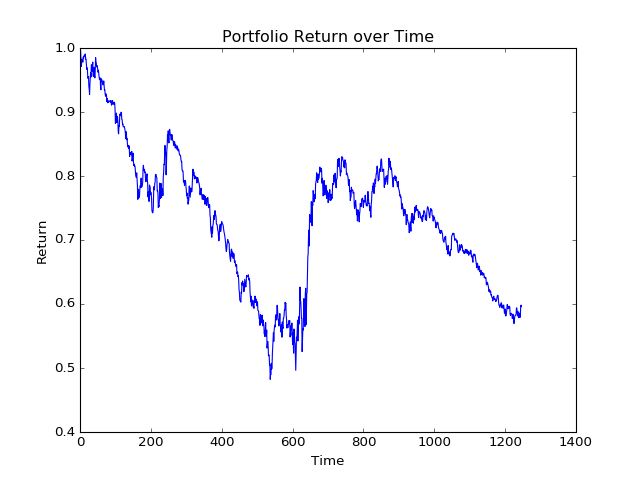

-0.104711639261 -0.490149508624


In [10]:
fig = plt.figure()
plt.plot(value_op_seq)
plt.title('Portfolio Return over Time')
plt.ylabel('Return')
plt.xlabel('Time')
return_seq = np.log(value_op_seq[1:] / value_op_seq[:-1])
annual_return = 252 * np.mean(return_seq)
sharpe = np.sqrt(252) * np.mean(return_seq) / np.std(return_seq)
print annual_return, sharpe